In [1]:
%pip install pandas matplotlib scipy seaborn xelatex

ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [13]:
import os
import argparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import glob
from scipy import stats
from scipy.signal import savgol_filter
from dateutil import tz
import itertools

In [5]:
from common import combine_csvs
from common import region_mapping
import common

In [3]:
N_REGIONS = 'Regions'
N_TIMESTAMP = 'Timestamp'
N_TYPE = 'Type'
N_LATENCY = 'Latency (ms)'

N_STARLINK = 'Starlink'
N_STARLINK_REMOTE = 'Starlink Remote'
N_HOME = 'Home'

REGION_ORDER = ['N. California', 'Tokyo', 'London', 'Sydney', 'Singapore',
            'Sao Paulo', 'Bahrain', 'Mumbai', 'Cape Town']

#src_dirs = ['data/trad_ping_2022-04-14', 'data/starlink_ping_2022-04-14/']
#src_dirs = ['data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/', 'data/starlink-data/Ping/2022-06-06_starlink_ping/']
#src_dirs = [
#    ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping/'), 
#    ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping/'),
#    ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping/'),
#    ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping/'),
#]

OUT_PATH = 'output/Ping'
filename = os.path.join(OUT_PATH, 'out_plot')

In [6]:
src_dirs = []
for folder in glob.glob('data/starlink-data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Starlink', folder))
for folder in glob.glob('data/Home_network_data/Ping/*'):
    if os.path.isdir(folder):
        src_dirs.append(('Home', folder))
        
#src_dirs = [(N_STARLINK_REMOTE, 'data/Koeye/koeye_ping_measurements_2022-05-20/')]
src_dirs

[('Starlink', 'data/starlink-data/Ping/2022-04-12_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-28_starlink_measurements_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-06-03_starlink_measurements_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-09_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-06-06_starlink_ping'),
 ('Starlink', 'data/starlink-data/Ping/2022-05-19_starlink_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-06-03_traditional_measures_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-04-14_trad_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-05-28_traditional_measures_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-06-06_traditional_measures_ping'),
 ('Home', 'data/Home_network_data/Ping/2022-04-09-trad_ping')]

In [17]:
plot_params = common.plot_params.copy()
plot_params['figure.figsize'] = (7.16, 4)
plot_params['figure.dpi'] = 300
#matplotlib.rcParams.update(plot_params)

sns_params = common.sns_params.copy()
sns_params['figure.figsize'] = (7.16, 4)
sns_params['figure.dpi'] = 300
sns_params['patch.edgecolor'] = 'black'
sns.set_theme("paper", style='whitegrid', rc=sns_params, color_codes=True, palette='bright')
#sns.set_context("paper", rc=sns_params)
#sns.set(rc=sns_params)

In [8]:
df_old = pd.read_csv(os.path.join(OUT_PATH, '2022-06-17_end_all_ping_data.csv'), index_col=False)
df_old[N_TIMESTAMP] = pd.to_datetime(df_old[N_TIMESTAMP])
df_old

,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
54583138,289.0,2022-06-17 08:39:47,Cape Town,Home,False
54583139,145.0,2022-06-17 08:39:47,London,Home,False
54583140,261.0,2022-06-17 08:39:47,Mumbai,Home,False
54583141,156.0,2022-06-17 08:39:47,Sydney,Home,False


In [8]:
df = pd.DataFrame()
for type_name, folder in src_dirs:
    for region in glob.glob(f'{folder}/*'):
        pattern = f"{region}/*"
        print(pattern)
        #print(pattern)
        df_temp = combine_csvs(glob.glob(pattern, recursive=True), None, header=None)
        df_temp = df_temp.iloc[:,[2, 3]]
        df_temp.rename(columns={df_temp.columns[0]: N_LATENCY, df_temp.columns[1]: N_TIMESTAMP}, inplace=True)
        df_temp[N_TIMESTAMP] = pd.to_datetime(df_temp[N_TIMESTAMP], unit='s')
        df_temp.sort_values(N_TIMESTAMP, inplace=True)
        df_temp[N_REGIONS] = region_mapping[os.path.basename(region)]
        df_temp[N_TYPE] = type_name

        if not df.empty:
            #df = df.merge(df_temp, how='outer', left_index=True, right_index=True)
            #df = df.update(df_temp, errors='raise')
            df = pd.concat([df, df_temp])
        else:
            df = df_temp
            
df = df.reset_index(drop=True)
df

data/Koeye/koeye_ping_measurements_2022-05-20/South_America_Sao_Paulo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Singapore/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Sydney/*
data/Koeye/koeye_ping_measurements_2022-05-20/Africa_Cape_Town/*
data/Koeye/koeye_ping_measurements_2022-05-20/US_West_N_California/*
data/Koeye/koeye_ping_measurements_2022-05-20/Middle_East_Bahrain/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Tokyo/*
data/Koeye/koeye_ping_measurements_2022-05-20/Europe_London/*
data/Koeye/koeye_ping_measurements_2022-05-20/Asia_Pacific_Mumbai/*


,Latency (ms),Timestamp,Regions,Type
0,240.0,2022-05-21 04:41:45,Sao Paulo,Starlink Remote
1,234.0,2022-05-21 04:41:46,Sao Paulo,Starlink Remote
2,244.0,2022-05-21 04:41:47,Sao Paulo,Starlink Remote
3,294.0,2022-05-21 04:41:48,Sao Paulo,Starlink Remote
4,226.0,2022-05-21 04:41:49,Sao Paulo,Starlink Remote
...,...,...,...,...
1315343,313.0,2022-05-23 15:51:11,Mumbai,Starlink Remote
1315344,311.0,2022-05-23 15:51:13,Mumbai,Starlink Remote
1315345,293.0,2022-05-23 15:51:14,Mumbai,Starlink Remote
1315346,306.0,2022-05-23 15:51:15,Mumbai,Starlink Remote


In [9]:
#df_temp = combine_csvs(glob.glob(f'{src_dirs[1]}/US_West_N_California/*', recursive=True), 3, header=None)
#df_temp.index = pd.to_datetime(df_temp.index, unit='s')
#df_temp.sort_index()
#df.loc['2022-06-17 01']

In [7]:
# https://stackoverflow.com/questions/69300483/how-to-use-markers-with-ecdf-plot
def ecdf(data, array: bool=True):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    if not array:
        return pd.DataFrame({'x': x, 'y': y})
    else:
        return x, y

In [10]:
# Discern outliers
N_OUTLIERS = 'Outliers'
df_outliers = df_old
zscore = np.abs(df_outliers.groupby([
    N_TYPE, N_REGIONS])[N_LATENCY].transform(
    lambda x : stats.zscore(x, ddof=1, nan_policy='omit')
))
df_outliers[N_OUTLIERS] = (np.abs(zscore) >= 3)
df_outliers = df_outliers.sort_values(N_LATENCY)
df_outliers

#df_starlink_no_outliers = df_starlink[
#    (np.abs(stats.zscore(df_starlink[N_LATENCY], nan_policy='omit')) < 3.5)
#]
#df_no_outliers = pd.concat([df_starlink_no_outliers, df_home_no_outliers]).reset_index(drop=True)
#df_no_outliers

,Latency (ms),Timestamp,Regions,Type,Outliers
16151839,25.6,2022-06-02 06:54:10,N. California,Home,False
1457351,25.8,2022-04-19 03:54:36,N. California,Home,False
28980302,25.9,2022-06-08 04:50:04,N. California,Home,False
91957,25.9,2022-04-15 04:45:30,N. California,Home,False
53669735,25.9,2022-06-17 00:40:08,N. California,Home,False
...,...,...,...,...,...
5043008,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
5043009,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
5043012,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
562526,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [12]:
df_combined = pd.concat([df_old, df_outliers])
print(df_combined.dtypes)
df_combined

Latency (ms)           float64
Timestamp       datetime64[ns]
Regions                 object
Type                    object
Outliers                  bool
dtype: object


,Latency (ms),Timestamp,Regions,Type,Outliers
0,57.4,2022-04-13 05:06:07,N. California,Starlink,False
1,47.8,2022-04-13 05:06:08,N. California,Starlink,False
2,61.9,2022-04-13 05:06:09,N. California,Starlink,False
3,52.9,2022-04-13 05:06:10,N. California,Starlink,False
4,51.0,2022-04-13 05:06:11,N. California,Starlink,False
...,...,...,...,...,...
5043008,13484.0,2022-05-11 21:06:27,Sao Paulo,Starlink,True
5043009,13524.0,2022-05-11 21:06:27,Sydney,Starlink,True
5043012,13572.0,2022-05-11 21:06:27,Singapore,Starlink,True
562526,13591.0,2022-04-16 13:33:57,Sydney,Starlink,True


In [ ]:
#df_outliers = df_outliers.sort_values(N_TIMESTAMP)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-17_end_all_ping_data.csv'), index=False)
#df_outliers.to_csv(os.path.join(out_path, '2022-06-21_end_koeye_ping_data.csv'), index=False)

In [20]:
# Filter
#df_processed = df_outliers[df_outliers[N_OUTLIERS] == False]
#df_processed = df.loc['2022-05-13 07:13:50':'2022-05-13 7:14:18']
#df_processed = df.loc['2022-06-05':'2022-06-05 01']

df_processed = df_old.groupby([N_OUTLIERS, N_TYPE, N_REGIONS]).resample('12H', on=N_TIMESTAMP).mean()
df_processed = df_processed.drop(N_OUTLIERS, axis=1).reset_index().dropna()
#df_processed.to_csv('output/out.csv')
df_processed

,Outliers,Type,Regions,Timestamp,Latency (ms)
0,False,Home,Bahrain,2022-05-09 00:00:00,226.796869
1,False,Home,Bahrain,2022-05-09 12:00:00,227.203799
2,False,Home,Bahrain,2022-05-10 00:00:00,229.839386
3,False,Home,Bahrain,2022-05-10 12:00:00,229.531344
4,False,Home,Bahrain,2022-05-11 00:00:00,230.947283
...,...,...,...,...,...
3063,True,Starlink,Tokyo,2022-06-15 00:00:00,316.595455
3064,True,Starlink,Tokyo,2022-06-15 12:00:00,330.363636
3065,True,Starlink,Tokyo,2022-06-16 00:00:00,357.548718
3066,True,Starlink,Tokyo,2022-06-16 12:00:00,322.344828


In [ ]:
df_regs_interp = df_processed.interpolate(method='linear')
#df_regs_interp = df_regs_interp.apply(lambda x: savgol_filter(x,41,1))
df_regs_interp

In [10]:
df_cdf = df_processed[df_processed[N_OUTLIERS] == False].groupby([N_TYPE, N_REGIONS])[N_LATENCY].apply(ecdf, False)
#df_cdf = df_processed.value_counts().sort_index().cumsum() * 1./len(df_processed)
df_cdf = df_cdf.reset_index().drop('level_2', axis=1)
df_cdf

,Type,Regions,x,y
0,Home,Bahrain,224.735891,0.001873
1,Home,Bahrain,224.801556,0.003745
2,Home,Bahrain,224.915184,0.005618
3,Home,Bahrain,224.921345,0.007491
4,Home,Bahrain,224.950236,0.009363
...,...,...,...,...
10025,Starlink,Tokyo,174.835597,0.993068
10026,Starlink,Tokyo,174.956534,0.994801
10027,Starlink,Tokyo,175.364149,0.996534
10028,Starlink,Tokyo,176.214612,0.998267


In [ ]:
#df_pivot = df_unstacked.pivot_table(index=[N_REGIONS, 'timestamp'], columns='type', values='latency')
#print(df_pivot.head())

g = sns.catplot(data=df_unstacked, x='type', y='latency', col=N_REGIONS, col_wrap=4, kind='box', height=2,
        aspect=0.895, showfliers=True)
g.set(yscale='log')
g.tight_layout()
(g.set_axis_labels('Provider', 'Latency (ms)')
        .set_titles("{col_name}"))

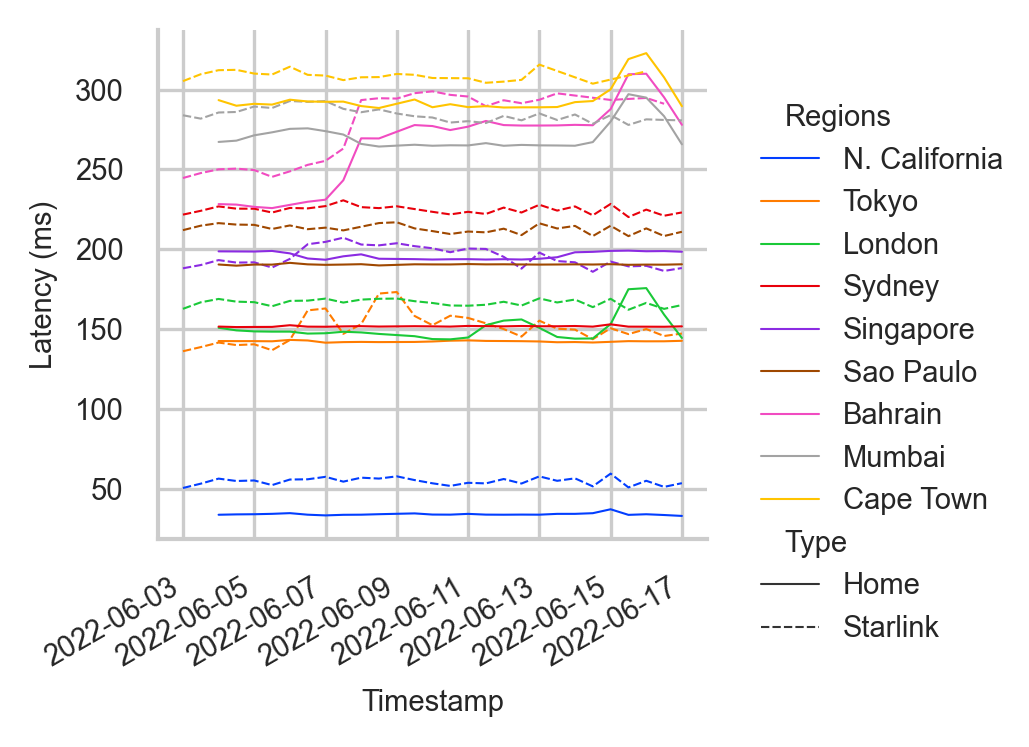

In [21]:
#fig, ax = plt.subplots(figsize=(7.16,4), dpi=100)
#fig, ax = plt.subplots(figsize=(20,10))
# 6.09 for full size, 2.5 for half size

df_time = df_processed.set_index(N_TIMESTAMP)['2022-06-03':].reset_index()

g_time = sns.relplot(data=df_time[df_time[N_OUTLIERS] == False], 
                     x=N_TIMESTAMP, y=N_LATENCY, 
                     hue_order=REGION_ORDER,
                     height=2.5, aspect=1,
                     kind='line',
                     palette='bright',
                     hue=N_REGIONS, style=N_TYPE)


g_time.figure.autofmt_xdate()
g_time.tight_layout()

In [22]:
g_time.savefig(f'{OUT_PATH}/2022-06-03_and_06_12hourly_ping.pdf', bbox_inches='tight')
#g_time.savefig(f'{OUT_PATH}/2022-06-03_and_06_hourly_ping_no_outliers.pdf', bbox_inches='tight')

In [17]:
df_sample = df_outliers[df_outliers[N_OUTLIERS] == False]
df_sample = df_sample.pivot_table(
    index=[N_REGIONS,N_TIMESTAMP],
    columns=N_TYPE,
    values=N_LATENCY,
    #aggfunc={N_LATENCY: np.mean,
    #         N_OUTLIERS: np.logical_or}
).reset_index()
#df_outliers_type = df_outliers[df_outliers[N_OUTLIERS] == True]
#df_outliers_type = df_outliers_type.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

# https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe
df_sample = df_sample.groupby([N_REGIONS]).sample(20000)
#df_sample = pd.concat([df_sample, df_outliers_type]).reset_index(drop=True)
df_sample

Type,Regions,Timestamp,Home,Starlink
879051,Bahrain,2022-06-03 12:58:01,NaN,237.0
1411656,Bahrain,2022-06-09 19:54:49,277.0,296.0
159881,Bahrain,2022-05-11 05:05:23,230.0,230.0
1853238,Bahrain,2022-06-14 22:38:15,280.0,NaN
772115,Bahrain,2022-06-01 05:33:25,263.0,241.0
...,...,...,...,...
18179443,Tokyo,2022-06-08 06:10:52,144.0,141.0
16943939,Tokyo,2022-05-09 19:56:44,143.0,160.0
18657062,Tokyo,2022-06-13 19:25:03,144.0,133.0
17096964,Tokyo,2022-05-11 14:27:15,140.0,164.0


In [ ]:
t = df_sample.dropna()
#t[t[N_OUTLIERS] == True]
t.sort_values(N_TIMESTAMP)

In [ ]:
df_out_sample = df_sample[df_sample[N_OUTLIERS] == True]
df_out_sample.sort_values([N_STARLINK, N_HOME]).to_csv(f'{out_path}/outliers.csv')

In [12]:
df_all = df_outliers[df_outliers[N_OUTLIERS] == False]
df_all = df_outliers.pivot_table(index=[N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()

In [19]:
df_sample

Regions           Timestamp Latency (ms)          Outliers         
Type                                          Home Starlink     Home Starlink
38007     Bahrain 2022-05-09 19:07:03        225.0    245.0      0.0      0.0
1423477   Bahrain 2022-06-09 23:11:51        278.0    321.0      0.0      0.0
660474    Bahrain 2022-05-30 22:32:42        227.0    244.0      0.0      0.0
897185    Bahrain 2022-06-03 18:28:21          NaN    237.0      NaN      0.0
568368    Bahrain 2022-05-29 20:57:26        227.0    246.0      0.0      0.0
...           ...                 ...          ...      ...      ...      ...
18393332    Tokyo 2022-06-10 18:09:26        140.0    152.0      0.0      0.0
17534719    Tokyo 2022-05-30 14:39:49        139.0    133.0      0.0      0.0
18274276    Tokyo 2022-06-09 08:48:18          NaN    178.0      NaN      0.0
18929911    Tokyo 2022-06-16 23:12:38        142.0    135.0      0.0      0.0
18454711    Tokyo 2022-06-11 11:12:26        143.0    150.0      0.0      0.0

[45000 rows x 6 columns]

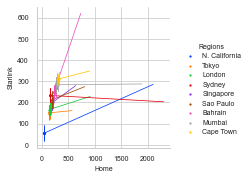

In [13]:
#df_type = df_processed.pivot_table(index=[N_OUTLIERS, N_REGIONS,N_TIMESTAMP], columns=N_TYPE, values=N_LATENCY).reset_index()
df_type = df_all
#df_type = df_type.dropna(subset=[N_HOME, N_STARLINK])
g_scatter = sns.lmplot(
    data=df_type,
    #col=N_OUTLIERS,
    x_bins=10,
    x_ci='sd',
    ci=None,
    x=N_HOME, y=N_STARLINK,
    hue=N_REGIONS, hue_order=REGION_ORDER,
    palette='bright',
    facet_kws={'sharex': False, 'sharey': False},
    scatter_kws={'s': 5, 'linewidth': 0},
    #markers='x',
    #scatter=False,
    height=2.5
)
#g_scatter = sns.displot(data=df_type[df_type[N_OUTLIERS] == False], x=N_HOME, y=N_STARLINK,
#                        binwidth=10, 
#                        hue=N_REGIONS, facet_kws={'sharex': False, 'sharey': False},
#                       height=3, palette='colorblind')

axes = g_scatter.axes.flatten()
#for ax in axes:
#    x0, x1 = ax.get_xlim()
#    y0, y1 = ax.get_ylim()
#    lims = [max(x0, y0), min(x1, y1)]
#    ax.plot(lims, lims, '-r')
#axes[1].set(yscale='log', xscale='log')
#g_scatter.set_titles(col_template="{col_name}")
g_scatter.tight_layout()

In [14]:
g_scatter.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_regression.pdf', bbox_inches='tight')

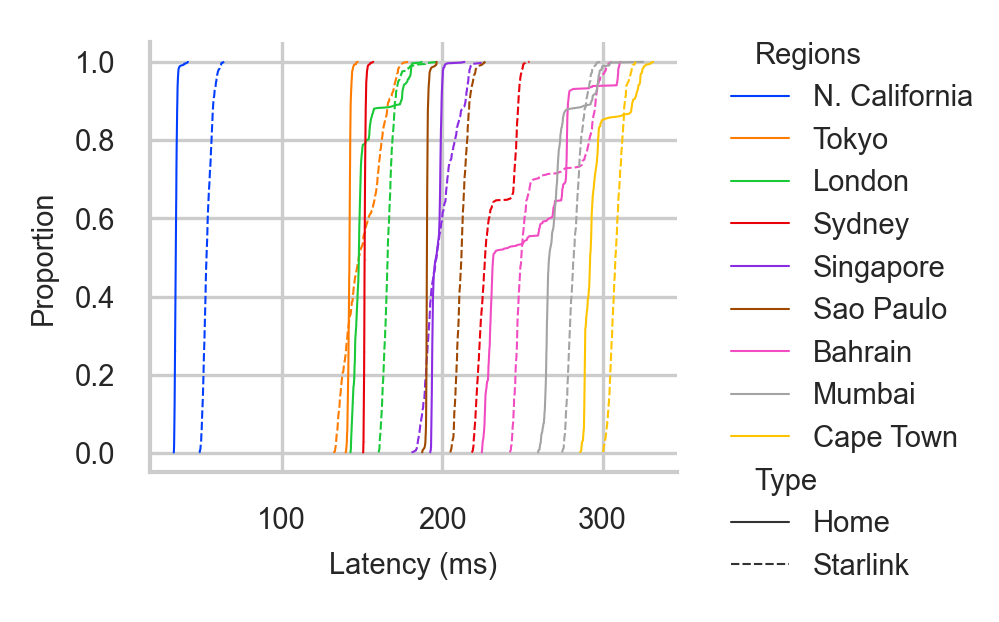

In [15]:
#fig, ax =df_sampleubplots(figsize=(3.5,2))
#fig, ax = plt.subplots(figsize=(7.16,2.5))
#fig_cdf, ax_cdf = plt.subplots(figsize=(7.16,2.5))

#g = sns.ecdfplot(data=df_unstacked, x='latency', hue='Type Region', ax=ax)
g_cdf = sns.relplot(data=df_cdf, x='x', y='y', hue=N_REGIONS, style=N_TYPE,
                hue_order=REGION_ORDER, kind='line', palette='bright',
                height=2, aspect=1.2)
#g.set(xscale='log')
#g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g_cdf.set(xlabel='Latency (ms)', ylabel='Proportion')
g_cdf.tight_layout()

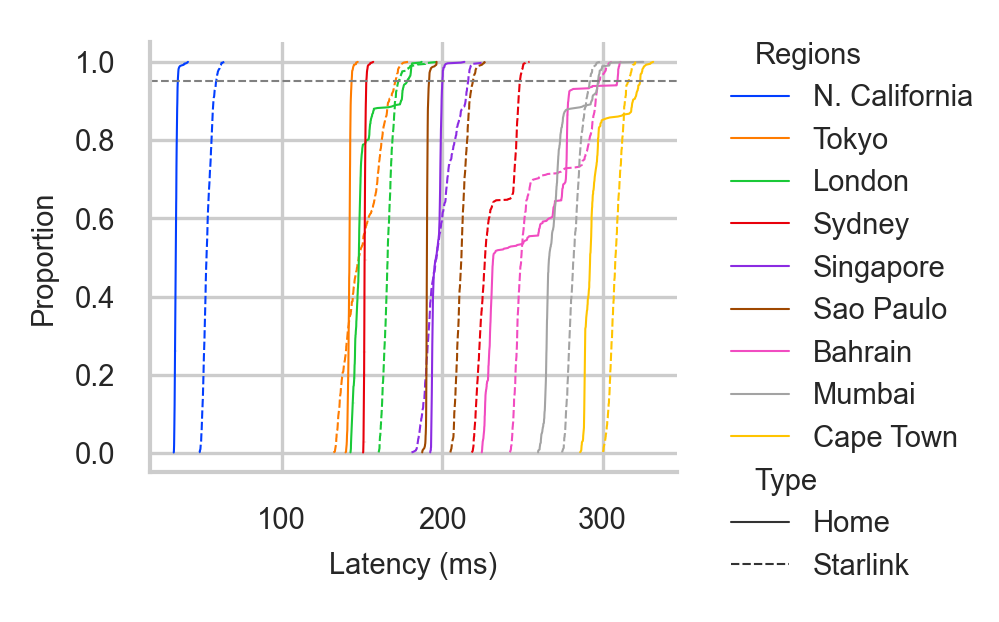

In [16]:
g_cdf.refline(y=0.95)
g_cdf.tight_layout()

In [17]:
g_cdf.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_cdf.pdf', bbox_inches='tight')
#fig.savefig(f'{filename}.pgf', bbox_inches='tight')

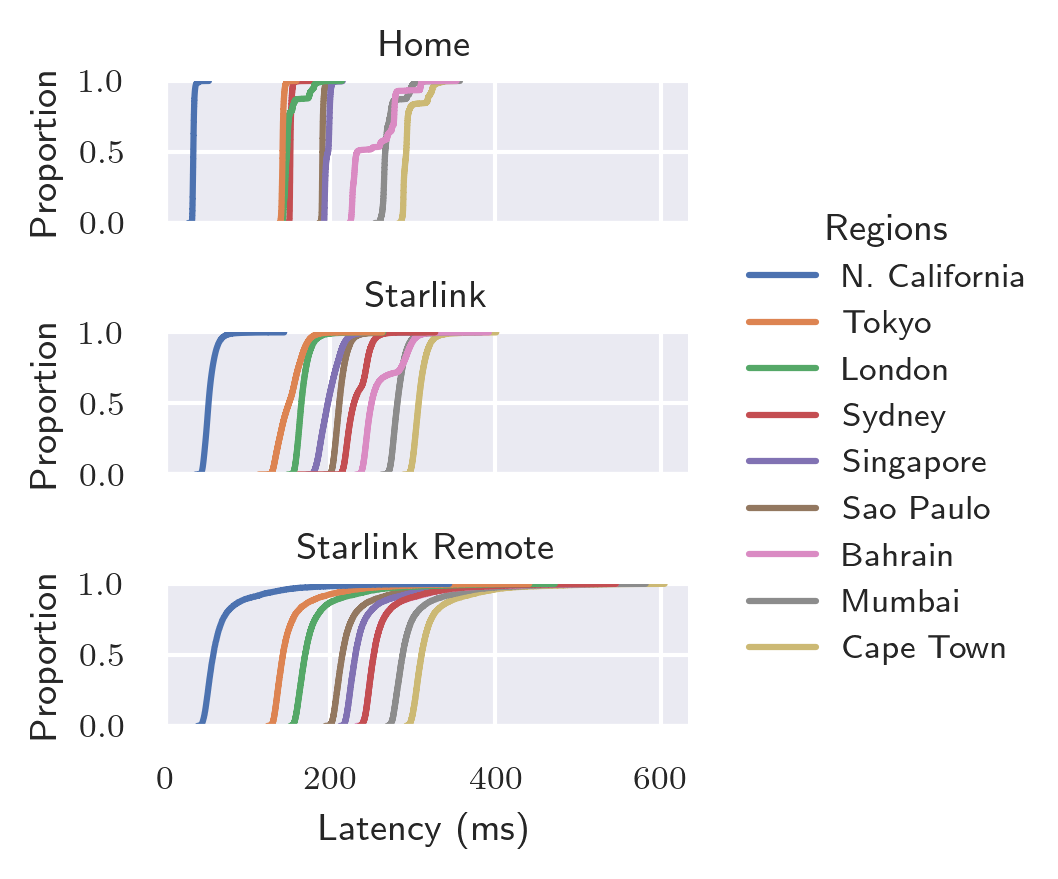

In [24]:
#_, ax_hist = plt.subplots(figsize=(7.16,4), dpi=300)

g_hist = sns.displot(
    data=df_processed[df_processed[N_OUTLIERS] == False], 
    x=N_LATENCY, 
    row=N_TYPE, 
    hue=N_REGIONS, hue_order=common.REGION_ORDER,
    #hue=N_TYPE, 
    kind='ecdf', height=1, aspect=2.5)
g_hist.set_titles(row_template="{row_name}")
g_hist.tight_layout()


In [ ]:
#g_hist.refline(y=0.9)
g_hist.refline(y=0.95)
#g_hist.refline(y=0.99)
g_hist.set_titles(col_template="{col_name}")
g_hist.tight_layout()

In [26]:
g_hist.savefig(f'{filename}_koeye_ping_cdf.pdf', bbox_inches='tight')

In [ ]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))

sns.set_palette('Greys')
#df_samp = df_combined.groupby([N_REGIONS]).sample(10000)
g_avg = sns.catplot(data=df_outliers,
                    sharey=False,
                    x=N_REGIONS, y=N_LATENCY, hue=N_TYPE,
                    hue_order=[N_HOME, N_STARLINK],
                    order=REGION_ORDER,
                    legend=False,
                    kind='bar',
                    palette=['C9', 'C0'],
                    ci='sd',
                    height=2, aspect=1.75)

num_locs = len(df_outliers[N_REGIONS].unique())
hatches = itertools.cycle(['', '//'])
axes = g_avg.axes.flatten()
for ax in axes:
    for i, bar in enumerate(ax.patches):
        if i % num_locs == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)
        
g_avg.figure.autofmt_xdate()
g_avg.set_titles(row_template="{row_name}")
g_avg.figure.legend(loc='upper left')
g_avg.tight_layout()

sns.set_palette('bright')

#df_averaged

In [19]:
g_avg.savefig(f'{OUT_PATH}/2022-06-17_end_all_ping_avg.pdf', bbox_inches='tight')

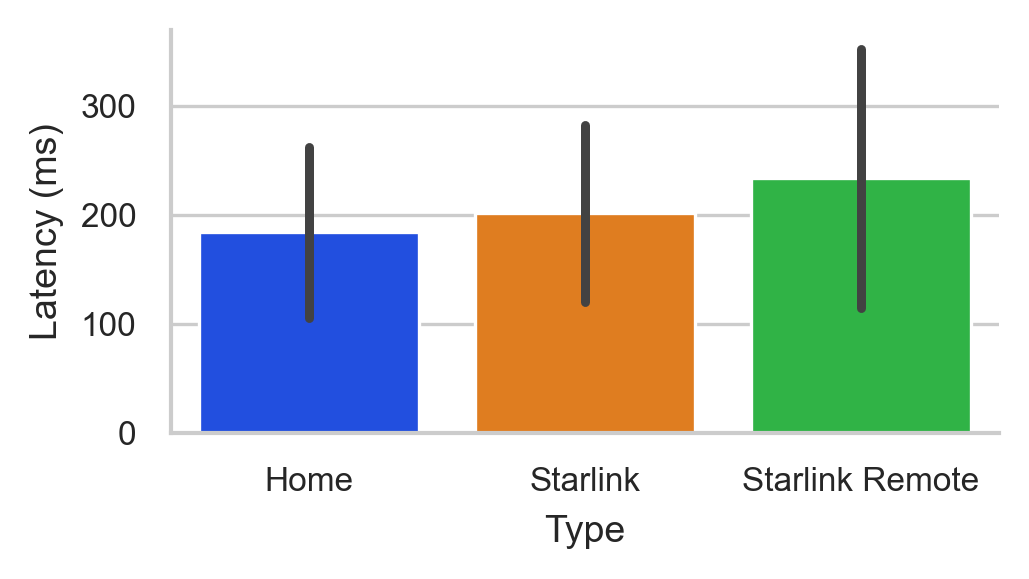

In [42]:
#temp = df_regs.loc['2022-06-03':]

#df_averaged = df.groupby([N_TYPE, N_REGIONS]).std().reset_index()

#styler = df_averaged.style
#styler.format(precision=2)
#styler.to_latex(os.path.join(OUTPUT_FOLDER, '2022-06-05_end_avg_bandwidth.tex'))
g_remote_avg = sns.catplot(data=df_combined,
                    sharey=False,
                    x=N_TYPE, y=N_LATENCY,
                    order=[N_HOME, N_STARLINK, N_STARLINK_REMOTE],
                    legend_out=False,
                    kind='bar', ci='sd',
                    height=2, aspect=1.75)

#g_avg.figure.autofmt_xdate()
g_remote_avg.set_titles(row_template="{row_name}")
g_remote_avg.tight_layout()

#df_averaged

In [25]:
#df_outliers[N_TYPE] = N_STARLINK_REMOTE
#df_outliers[N_TYPE] = df_outliers[N_TYPE].map({'Starlink Koeye': N_STARLINK_REMOTE})

In [26]:
g_remote_avg.savefig(f'{OUT_PATH}/2022-06-21_remote_ping_avg.pdf', bbox_inches='tight')

In [28]:
nt_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.90)
nf_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.95)
nn_perc = df_combined.groupby([N_TYPE, N_REGIONS]).quantile(.99)

In [30]:
def diff_table(percentile):
    df_perc = percentile.reset_index().pivot(index=N_REGIONS, columns=N_TYPE, values=N_LATENCY)
    df_perc['diff'] = df_perc[N_STARLINK_REMOTE] - df_perc[N_STARLINK]
    return df_perc.reset_index().pivot_table(columns=N_REGIONS, values='diff')
    
df_perc = diff_table(nt_perc)
df_perc = pd.concat([df_perc, diff_table(nf_perc)])
df_perc = pd.concat([df_perc, diff_table(nn_perc)])
df_perc['Percentile'] = ['90%', '95%', '99%']
df_perc = df_perc.set_index('Percentile')
df_perc

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Percentile,,,,,,,,,
90%,-4.00,28.0,31.0,32.0,33.5,30.0,57.0,45.0,12.0
95%,50.00,83.0,83.0,85.0,84.1,80.0,113.0,98.0,65.0
99%,465.51,492.0,499.0,493.0,496.0,495.0,532.0,517.0,486.0


In [13]:
df_type_avg = df_old.groupby(
    [N_REGIONS, N_TYPE]
).mean()
#apply(lambda x: x[N_HOME] - x[N_STARLINK])
df_type_avg

Latency (ms)  Outliers
Regions       Type                            
Bahrain       Home        258.341745  0.003269
              Starlink    266.696232  0.004873
Cape Town     Home        296.039889  0.005587
              Starlink    310.377467  0.006808
London        Home        152.046133  0.006495
              Starlink    168.085194  0.006616
Mumbai        Home        271.701787  0.001215
              Starlink    284.594823  0.005380
N. California Home         34.491404  0.008420
              Starlink     55.383745  0.006195
Sao Paulo     Home        191.006578  0.009956
              Starlink    213.843563  0.005903
Singapore     Home        196.848192  0.010495
              Starlink    198.684958  0.005600
Sydney        Home        152.464079  0.012172
              Starlink    230.887662  0.004760
Tokyo         Home        142.680309  0.010560
              Starlink    151.918970  0.004970

In [17]:
df_type_avg.groupby([N_REGIONS])[N_LATENCY].diff()

Regions        Type    
Bahrain        Home              NaN
               Starlink     8.354487
Cape Town      Home              NaN
               Starlink    14.337578
London         Home              NaN
               Starlink    16.039061
Mumbai         Home              NaN
               Starlink    12.893036
N. California  Home              NaN
               Starlink    20.892341
Sao Paulo      Home              NaN
               Starlink    22.836985
Singapore      Home              NaN
               Starlink     1.836766
Sydney         Home              NaN
               Starlink    78.423583
Tokyo          Home              NaN
               Starlink     9.238661
Name: Latency (ms), dtype: float64

In [110]:
df_star = df_outliers[df_outliers[N_TYPE] == N_STARLINK]
df_corr = df_star.pivot_table(index=N_TIMESTAMP, columns=N_REGIONS, values=N_LATENCY)
df_corr

In [112]:
df_corr = df_corr.corr()
df_corr

Regions,Bahrain,Cape Town,London,Mumbai,N. California,Sao Paulo,Singapore,Sydney,Tokyo
Regions,,,,,,,,,
Bahrain,1.000000,0.531023,0.435916,0.523741,0.368044,0.512611,0.474942,0.352300,0.510409
Cape Town,0.531023,1.000000,0.530960,0.615328,0.538009,0.629372,0.617139,0.696385,0.526976
London,0.435916,0.530960,1.000000,0.533721,0.513696,0.515329,0.561255,0.494996,0.577317
Mumbai,0.523741,0.615328,0.533721,1.000000,0.493145,0.567466,0.569023,0.640166,0.498123
N. California,0.368044,0.538009,0.513696,0.493145,1.000000,0.483147,0.457279,0.390160,0.540791
Sao Paulo,0.512611,0.629372,0.515329,0.567466,0.483147,1.000000,0.492273,0.500691,0.555297
Singapore,0.474942,0.617139,0.561255,0.569023,0.457279,0.492273,1.000000,0.600782,0.609283
Sydney,0.352300,0.696385,0.494996,0.640166,0.390160,0.500691,0.600782,1.000000,0.538216
Tokyo,0.510409,0.526976,0.577317,0.498123,0.540791,0.555297,0.609283,0.538216,1.000000


In [82]:
file_path = os.path.join('output/Ping/', 'Percentiles.tex')
styler = df_perc.style
styler.format(precision=1)
styler.to_latex(file_path)